#### Q-LEARNING IN A CONTINUOUS ENVIRONMENT

EXTRACTED and quoted FROM:
- https://eckronsoftware.wordpress.com/2018/12/26/q-learning-with-cartpole/
- https://github.com/ehennis/ReinforcementLearning/blob/master/02-QLearning.ipynb

CART POLE
"The actions are 0 to push the cart to the left and 1 to push the cart to the right.

The continuous state space is an X coordinate for location, the velocity of the cart, the angle of the pole, and the velocity at the tip of the pole. The X coordinate goes from -4.8 to +4.8, velocity is -Inf to +Inf, angle of the pole goes from -24 degrees to +24 degrees, tip velocity is -Inf to +Inf. With all of the possible combinations you can see why we can't create a Q table for each one.

To "solve" this puzzle you have to have an average reward of > 195 over 100 consecutive episodes"

In [109]:
import numpy as np #for array manipulation
import gym # pull the cart pole environment from Open AI.
# from gym import wrappers
# import random
# import time
# import math
# from IPython.display import clear_output


import matplotlib.pyplot as plt
import gc
gc.disable() #Disable automatic garbage collection.

In [110]:
#Create the Environment
envCartPole = gym.make('CartPole-v1')
start = envCartPole.reset()
print('Here is the starting tuple with the 4 continuous variables:')
print(start)

Here is the starting tuple with the 4 continuous variables:
[ 0.03533205  0.03968629 -0.01643508 -0.01905855]


### TEST APPLICATION TO GET COMMON VARIABLES

- Explore the state space to get an idea of possible combinations. 
- Since we are trying to use the FULL environment, ensure that you are not just pushing and pulling in the center location.
- Loop through 1,000 episodes to get sample space of variables in the state space. The idea for this code comes from Miquel Morales who created a compliment to the GT Reinforcement Learning class.

In [111]:
observations = []
for episode in range(1000): #1k episodes should give us enough data
    observation = envCartPole.reset()
    for step in range(100): #Do only 100 steps per episode unless we finish
        observations.append(observation)
        action = envCartPole.action_space.sample()
        if episode < 25: #First 20 episodes only go left
            action = 0
        elif episode < 50: #Next 20 episodes only go right
            action = 1
        observation, reward, done, info = envCartPole.step(action)
        if done: #Fell or hit the goal
            break
envCartPole.close()
x_vals = np.array(observations)[:,0]
xd_vals = np.array(observations)[:,1]
a_vals = np.array(observations)[:,2]
ad_vals = np.array(observations)[:,3]
y = np.zeros_like(x_vals)

Plot each of these variables to see their range in our sample. Using the graph below you can see the range of the X coordinate to range from about -1 to 1.

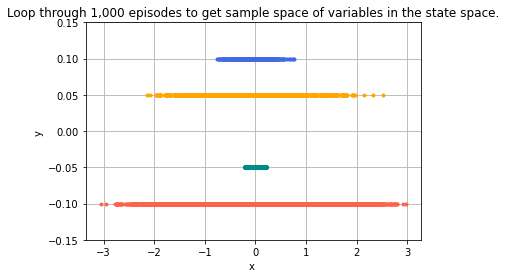

In [112]:
#Plot results 
plt.plot(x_vals, y + 0.10, '.', color="royalblue") # X Coordinate
plt.plot(xd_vals, y + 0.05, '.', color="orange") # Cart Velocity
plt.plot(a_vals, y - 0.05, '.', color="darkcyan") # Pole Angle
plt.plot(ad_vals, y - 0.10, '.', color="tomato") # Pole tip velocity
plt.xlabel("x ")
plt.ylabel("y ")
plt.title("Loop through 1,000 episodes to get sample space of variables in the state space.")
plt.grid()
plt.ylim([-0.15, 0.15])
plt.show()



# #Plot results 
# %matplotlib inline
# #Name x-axis, y-axis and whole graph
# plt.xlabel("episodes")
# plt.ylabel("average rewards")
# plt.title("FROZEN LAKE: AVG reward per 1000 episodes")


"Using the graph above you can see the range of the X coordinate to range from about -1 to 1. In OpenAI's GitHub, it is stated that this number should range from -4.8 to 4.8. Why do you think we didn't get that? Hopefully, you see that with our random action generation that we never held the pole up long enough to reach the edge. You would have to have a fairly functional learner to keep the pole balanced long enough to reach the edge."

Here are the actual thresholds from teh environment:

In [113]:
print(envCartPole.env.observation_space.low)
print(envCartPole.env.observation_space.high)

x_thres = ((envCartPole.env.observation_space.low/2)[0],
           (envCartPole.env.observation_space.high/2)[0])
a_thres = ((envCartPole.env.observation_space.low/2)[2],
           (envCartPole.env.observation_space.high/2)[2])

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


### DISCRETIZATION

Since we have the common variables from the above test application we can go ahead and start to box these values up into groups that we can make discrete. To do this we can use the numpy method linspace that will return evenly spaced numbers.

##### Here I will do the grouping for the X coordinate

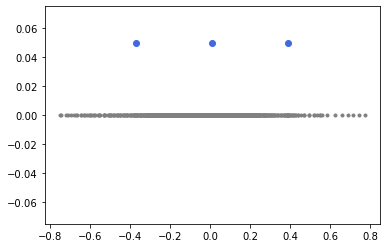

In [114]:
#X COORDINATE
x1 = np.linspace(np.min(x_vals), np.max(x_vals),
                 4, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o', color="royalblue")
plt.plot(x_vals, y, '.', color="grey")
plt.show()

##### Here is the X velocity variable

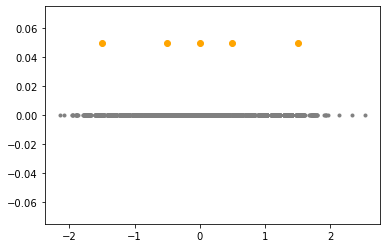

In [115]:
#X CART VELOCITY
xd1 = np.sort(np.append(np.linspace(-1.5,1.5,4,endpoint=True),0))
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075,0.075])
plt.plot(xd1, y1, 'o', color="orange")
plt.plot(xd_vals, y, '.', color="grey")
plt.show()

##### Here is the pole angle variable

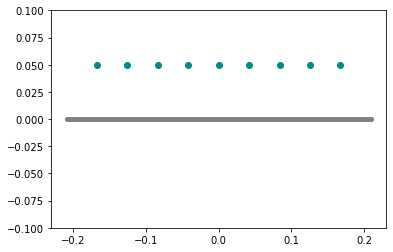

In [116]:
# POLE ANGLE
a1 = np.sort(np.linspace(a_thres[0], a_thres[1],
                         10, endpoint=False)[1:])
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o', color="darkcyan")
plt.plot(a_vals, y, '.', color="grey")
plt.show()

##### Here is the pole tip velocity

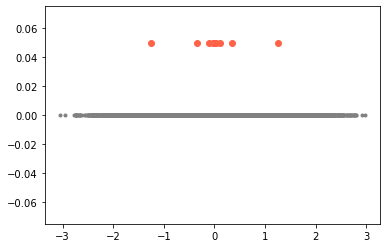

In [117]:
# POLE TIP VELOCITY
# 
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o', color="tomato")
plt.plot(ad_vals, y, '.', color="grey")
plt.show()

In [118]:
x1

array([-0.3707319 ,  0.00992296,  0.39057781])

Here we will use the digitize method to determine which bucket the X coordinate would fall into. 

In [119]:
print(np.digitize(-.7, x1))
print(np.digitize(-0.25, x1))
print(np.digitize(0, x1))
print(np.digitize(0.17, x1))
print(np.digitize(5, x1))

0
1
1
2
3


#### Q TABLE

"This gives you an idea how we can group the X coordinates based on the buckets we created.

Here are all the buckets in a single graph to give you an idea of our Q table."

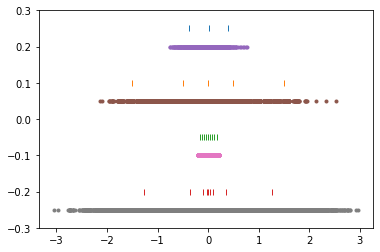

In [120]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.ylim([-0.3, 0.3])

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')
plt.show()

Now, knowing how we are going to turn our continous environment into a discrete Q table we can move forward with the Q-learning algorithm. It will be very similar to the previous one. 

Update learning_schedule and action_selection to try and beat the scores. Either with fewer episodes or higher max values.

### The following 3 method can be updated to change the functionality of the Q-Learner algorithm. Update these to try and solve the environment in less episodes or reach a higher maximum value

In [121]:
#Rate at which we set the learning rate. Typically, I keep this constant but much smarter people than myself
#have altered this value. Either by burning it down each episode or doing a step down where they keep the
#value constant for X episodes and then drop it.
def learning_schedule(e, max_episode):
    return 0.8

In [122]:
#Action selection AKA explore/exploit. Much like the learning rate this can either burn down or step down
def action_selection(state, Q, e, max_episodes):
    #0-1k: 100% explore
    #1k-2k: 80%
    #2k-3k: 75%
    #3k-4k: 50%
    #4k-5k: 0%
    if e < 1000:
        epsilon = 0.99
    elif e < 2000:
        epsilon = 0.50
    elif e < 3000:
        epsilon = 0.25
    elif e < 4000:
        epsilon = 0.05
    else:
        epsilon = 0
    action = np.random.randint(Q.shape[1]) if np.random.random() < epsilon else np.argmax(Q[state])


This is a copy of what was created above for the buckets but I recreated it here to make it easier to change them in a single spot.

In [123]:
def build_buckets():
    observations = []
    for episode in range(1000): #1k episodes should give us enough data
        observation = envCartPole.reset()
        for step in range(100): #Do only 100 steps per episode unless we finish
            observations.append(observation)
            action = envCartPole.action_space.sample()
            if episode < 25: #First 20 episodes only go left
                action = 0
            elif episode < 50: #Next 20 episodes only go right
                action = 1
            observation, reward, done, info = envCartPole.step(action)
            if done: #Fell or hit the goal
                break
    envCartPole.close()
    x_vals_loc = np.array(observations)[:,0]
    xd_vals_loc = np.array(observations)[:,1]
    a_vals_loc = np.array(observations)[:,2]
    ad_vals_loc = np.array(observations)[:,3]
    y = np.zeros_like(x_vals_loc)

    x_thres_loc = ((envCartPole.env.observation_space.low/2)[0],
           (envCartPole.env.observation_space.high/2)[0])
    a_thres_loc = ((envCartPole.env.observation_space.low/2)[2],
           (envCartPole.env.observation_space.high/2)[2])

    x1_loc = np.linspace(np.min(x_vals_loc), np.max(x_vals_loc), 4, endpoint=False)[1:]
    xd1_loc = np.sort(np.append(np.linspace(-1.5,1.5,4,endpoint=True),0))
    a1_loc = np.sort(np.linspace(a_thres_loc[0], a_thres_loc[1],10, endpoint=False)[1:])
    all_vals_loc = np.sort(np.append(
        (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
         -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
    idxs_loc = np.where(np.abs(all_vals_loc) < 2)
    ad1_loc = all_vals[idxs_loc]

    return (x1_loc, xd1_loc, a1_loc, ad1_loc)

Here is the method that will convert the 4 observations (X coordinate for location, the velocity of the cart, the angle of the pole, and the velocity at the tip of the pole) into a single state in the Q table. It grabs the bin for each of the 4 observations and then concatenate them into a string.

For example, if the X coordinate is 0.04 and that is bin 1, x velocity is 0.02 and that is bin 2, angle is 0.02 and that is bin 1, and tip velocity is 0.04 and that is bin 6 it will get converted to Q table index 1216.

To use the previous example, we knew the state space of the FrozenLake was 8 spaces so we could just use the index 1 through 8 to find the Q table location. Since we don't have that we can ensure we have enough space by putting the first observations (X coord) as the 1000s digit, second observations (x velocity) as the 100s digit, third observations (angle) as the 10s digit, and the fourth observations (tip velocity) as the 1s digit. This adds some bloat if you have less than 10 bins per state but this makes the math easy.

In [124]:
def observation_to_state(observation, bucket):
    disc_state = []
    for i in range(len(observation)):
        disc_state.append(int(np.digitize(observation[i], bins=bucket[i])))
    state = int(''.join(map(lambda feature: str(int(feature)), disc_state)))
    return state

Here is the Q-Learning algorithm

In [125]:
def q_learning_continuous(env, buckets):
    gamma = 0.99
    rewards = []    

    nS = 10 * 10 * 10 * 10 #I have 4 observations so I need 4 bits
    nA = envCartPole.action_space.n
    Q = np.random.random((nS,nA)) #Initialize the Q table to all random numbers
    episodes = 5000
    for e in range(episodes):
        observation = envCartPole.reset()
        state = observation_to_state(observation, buckets)
        total_reward = 0
        while True:
            #envCartPole.render() #####################################################
            action = action_selection(state, Q, e, episodes) #Grab the action
            observation, reward, done, infor = env.step(action)
            nstate = observation_to_state(observation,buckets)
            total_reward += reward

            alpha = learning_schedule(e,episodes)

            #Q Function Update
            #(not done) keeps the terminal state as 0
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate

            if done:
                rewards.append(total_reward) #Keep track of the total rewards per episode
                break
    return Q, rewards

#envCartPole.close() ##################################################


Here is the calling code

In [126]:
buckets = build_buckets() #Create the buckets
Q, rewards = q_learning_continuous(envCartPole, buckets)
envCartPole.close()
print(Q) #Here is the Q table. It will only print part of it but it shows the 2 actions per state

AssertionError: None (<class 'NoneType'>) invalid

Here we wil graph the results. Hopefully, you will see the rolling averge break the red "goal" line. One thing to note is look how the rolling average changes based on your epsilon and alpha changes.

In [ ]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards, color='grey')
plt.plot(rolling_average, color='y')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#NOTE: These are the epsilon changes in my original code
plt.axvline(x=1000, color='g', linestyle='-')
plt.axvline(x=2000, color='g', linestyle='-')
plt.axvline(x=3000, color='g', linestyle='-')
plt.axvline(x=4000, color='g', linestyle='-')
plt.ylim( (0,300) )
plt.show()